In [1]:
import pandas as pd
import numpy as np
import itertools

### In the cell below we read in the ratings, titles, and names data frames
### We then make a list of unique movies contained within the titles dataframe

In [2]:
df_ratings = pd.read_csv('data/ratings.tsv',sep = '\t') 
titles = pd.read_csv('data/titles.tsv',sep='\t')
names = pd.read_csv('data/names.tsv',sep = '\t')
movies = titles[titles['titleType']=='movie']
movies = list(movies['tconst'].unique())

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### We could not use every single movie because the principals data frame is  ~ 45 million rows long.
### We filtered the movies by a year, average rating, and number of ratings thresholds
### The function filterMovies returns a list of movies that fit the thresholds passed in to the function

In [43]:
##get a list of movies based on a rating threshold and year threshold
def filterMovies(ratingThreshold,yearThreshold,dfratings,dftitles):
    avgVotes = 50000
    qualifiedMovies = []
    len(df_ratings)
    boolean_series = dfratings.tconst.isin(movies)
    dfratings = dfratings[boolean_series]
    for row in dfratings.iterrows():
        if row[1]['numVotes'] >= avgVotes:
            if row[1]['averageRating'] >= ratingThreshold:
                qualifiedMovies.append(row[1]['tconst'])
    qualifiedMoviesFinal = []
    for movie in qualifiedMovies:
        year = (list(dftitles[dftitles['tconst']==movie]['startYear'])[0])
        if type(year) == str:
            year = int(year)
        if year >= yearThreshold:
            qualifiedMoviesFinal.append(movie)
    return qualifiedMoviesFinal

### In the cell below we get a list of movies made from 1950 on with no average rating filter.  
### For less powerful computers, if you are checking to see if the code runs and dont want to wait you can increase the year and the rating filters, but this will make the rating results less accurate at the end of the notebook

In [44]:
qualifiedMovies = filterMovies(0,1950,df_ratings,titles)
print(len(qualifiedMovies))

3411


### Here is where we actually run a priori on the principals data set.
### We read in the data by chunks of 1 million.  
### For every chunk we go through every actor in every qualified movie and add them and a list of their movies to a frequent actors dictionary
### Finally we filter out any actors who did not reach our support threshold parameter and return the final dict

In [46]:
## find the frequent actors in the list of movies that meets the support threshold
def findFreqActors(qMovies,s):
    count = 0
    freqActors = dict()
    for chunk in pd.read_csv('data/principals.tsv' ,sep='\t', chunksize = 1000000, usecols = ['tconst','category','nconst']):
        chunk = chunk[chunk['category']=='actor']
        chunk = chunk.groupby('tconst')
        for name, group in chunk:
            if name not in qMovies:
                continue
            else:
                actors = group['nconst'].unique()
                for actor in actors:
                    if actor in freqActors:
                        freqActors[actor][0] += 1
                        if name in qMovies:
                            freqActors[actor][1].append(name)
                    else:
                        freqActors[actor] = [1,[name]]
    freqActorsFinal = dict()
    for actor in freqActors:
        if freqActors[actor][0] >= supportThreshold:
            freqActorsFinal[actor] = freqActors[actor]
    return freqActors

### In the two cells below, we get the frequent actors with a support threshold of 2 and then we wrote a quick helper function to help us get the intersection of movies between actors

In [112]:
freqActors = findFreqActors(qualifiedMovies,2)

In [174]:
def andFunction(movies1,movies2):
    movieReturn = []
    for movie in movies1:
        if movie in movies2:
            movieReturn.append(movie)
    return movieReturn

['tt0120903', 'tt0290334', 'tt1877832']


388


### In the cell below we have the function to find frequent pairs
### We simply go through all the actors for each actor (a nested loop) and add all pairs of actors and the movies they are in together to the pair dictionary
### Finally we filter again for the support threshold to pick out pairs that have a certain number of movies together

### In the following cell we run the function with a support threshold of 3 to get our frequent pairs

In [116]:
def findPairs(frequentActors,s):
    freqPairs = dict()
    for actor in frequentActors:
        for actor2 in frequentActors:
            if actor == actor2 or (actor2,actor) in freqPairs:
                continue
            else:
                movies_together = []
                for movie in frequentActors[actor][1]:
                    if movie in frequentActors[actor2][1]:
                        movies_together.append(movie)
                for movie in frequentActors[actor2][1]:
                    if movie in frequentActors[actor][1] and movie not in movies_together:
                        movies_together.append(movie)
                freqPairs[(actor,actor2)] = [len(movies_together),movies_together]
    final = dict()
    for pair in freqPairs:
        if freqPairs[pair][0] >= s:
            final[pair] = freqPairs[pair]
    return final

In [233]:
freqPairs = findPairs(freqActors,3)
print(len(freqPairs))

116


### Below is the function to find frequent triples from the frequent pairs for a given support threshold.

### If all subsets of the triple exist within the pairs dict then we add it to the triples dictionary along with a list of their movies together

### Once again we filter for the support threshold and return the dictionary

In [250]:
def freqTriples(frequent_pairs,s):
    fTriples = dict()
    for pair in frequent_pairs:
        for pair2 in frequent_pairs:
            if pair[1] == pair2[0] and (pair[0],pair2[1]) in frequent_pairs:
                actors = [pair[0],pair[1],pair2[1]]
                moviesTogether = []
                movies12 = frequent_pairs[pair][1]
                movies23 = frequent_pairs[pair2][1]
                movies13 = frequent_pairs[(pair[0],pair2[1])][1]
                movies12_23 = andFunction(movies12,movies23)
                movies_allthree = andFunction(movies12_23,movies13)
                fTriples[(pair[0],pair[1],pair2[1])] = [len(movies_allthree),movies_allthree]
    triplesFinal = dict()
    for triple in fTriples:
        if fTriples[triple][0] >= s:
            triplesFinal[triple] = fTriples[triple]
    return triplesFinal

### Below are helper functions to help print results of our frequent duos

### getName simply returns the actual name from an nconst value

### get solo movies takes a pair and returns a list of all the movies each actor did on their own (without the other)

### get ratings takes a list of tconst (title keys) and returns the average rating for these titles

In [251]:
def getName(nconst):
    return list(names[names['nconst']==nconst]['primaryName'])[0]
    
def getSoloMovies(name1,name2,pairsDict,soloDict):
    name1solomovies = []
    name2solomovies = []
    for movie in soloDict[name1][1]:
        if movie not in pairsDict[(name1,name2)][1]:
            name1solomovies.append(movie)
    for movie in soloDict[name2][1]:
        if movie not in pairsDict[(name1,name2)][1]:
            name2solomovies.append(movie)
    for movie in name1solomovies:
        if movie in name2solomovies:
            pairsDict[(name1,name2)][1].append(movie)
            name1solomovies.remove(movie)
            name2solomovies.remove(movie)
    return name1solomovies,name2solomovies
def getRatings(movies):
    ratings = []
    if len(movies) == 0:
        return 0
    for movie in movies:
        if len(list(df_ratings[df_ratings['tconst']== movie]['averageRating']))>0:
            ratings.append(list(df_ratings[df_ratings['tconst']== movie]['averageRating'])[0])
    rating = np.mean(ratings)
    return rating

### The following helper function goes through every pair in the frequent pairs and prints the results of their ratings

### More specifically the average rating for the duo is printed along with each actors individual average rating (without their dynamic duo) and whether it was more or less than that of the duo together

In [252]:
def displayDuoResults(frequentPairs,frequentActors):
    print("SOLO RATINGS MEANS WITHOUT THE OTHER ACTOR")
    finalRatings = dict()
    for pair in frequentPairs:
        movies1,movies2 = getSoloMovies(pair[0],pair[1],frequentPairs,frequentActors)
        ratings1 = getRatings(movies1)
        ratings2 = getRatings(movies2)
        Cratings = getRatings(frequentPairs[pair][1])
        print("The Duo of: ", getName(pair[0]), " and ", getName(pair[1]), " had an average rating of: ", getRatings(frequentPairs[pair][1]))
        keyword1 = "greater"
        keyword2 = "greater"
        finalRatings[pair] = Cratings
        if ratings1 < Cratings:
            keyword1 = "lower"
        elif ratings1 == Cratings:
            keyword1 = "the same"
        if ratings2 < Cratings:
            keyword2 = "lower"
        elif ratings2 == Cratings:
            keyword2 = "the same"
        print(getName(pair[0]), "'s solo average Rating: ", getRatings(movies1), " which was ", keyword1)
        print(getName(pair[1]), "'s solo average Rating: ", getRatings(movies2), "which was ",keyword2) 

In [255]:
displayDuoResults(freqPairs,freqActors)

SOLO RATINGS MEANS WITHOUT THE OTHER ACTOR
The Duo of:  Hugh Jackman  and  Patrick Stewart  had an average rating of:  7.5
Hugh Jackman 's solo average Rating:  6.936842105263157  which was  lower
Patrick Stewart 's solo average Rating:  6.7 which was  lower
The Duo of:  Hugh Jackman  and  Ian McKellen  had an average rating of:  7.324999999999999
Hugh Jackman 's solo average Rating:  6.999999999999998  which was  lower
Ian McKellen 's solo average Rating:  7.822222222222221 which was  greater
The Duo of:  Dustin Hoffman  and  Jack Black  had an average rating of:  7.3
Dustin Hoffman 's solo average Rating:  7.405882352941176  which was  greater
Jack Black 's solo average Rating:  6.4437500000000005 which was  lower
The Duo of:  Al Pacino  and  Robert De Niro  had an average rating of:  7.75
Al Pacino 's solo average Rating:  7.157894736842105  which was  lower
Robert De Niro 's solo average Rating:  7.091304347826087 which was  lower
The Duo of:  Robert De Niro  and  Harvey Keitel  ha

Samuel L. Jackson 's solo average Rating:  6.659375 which was  lower
The Duo of:  Keanu Reeves  and  Laurence Fishburne  had an average rating of:  7.525
Keanu Reeves 's solo average Rating:  6.709090909090909  which was  lower
Laurence Fishburne 's solo average Rating:  6.716666666666668 which was  lower
The Duo of:  Keanu Reeves  and  Hugo Weaving  had an average rating of:  7.566666666666666
Keanu Reeves 's solo average Rating:  6.739130434782608  which was  lower
Hugo Weaving 's solo average Rating:  7.1000000000000005 which was  lower
The Duo of:  Liam Neeson  and  Ralph Fiennes  had an average rating of:  6.8
Liam Neeson 's solo average Rating:  6.704347826086955  which was  lower
Ralph Fiennes 's solo average Rating:  7.15 which was  greater
The Duo of:  Laurence Fishburne  and  Hugo Weaving  had an average rating of:  7.566666666666666
Laurence Fishburne 's solo average Rating:  6.814285714285715  which was  lower
Hugo Weaving 's solo average Rating:  7.1000000000000005 which w

The Duo of:  Elijah Wood  and  Ian McKellen  had an average rating of:  8.8
Elijah Wood 's solo average Rating:  6.766666666666667  which was  lower
Ian McKellen 's solo average Rating:  7.33 which was  lower
The Duo of:  Elijah Wood  and  Orlando Bloom  had an average rating of:  8.8
Elijah Wood 's solo average Rating:  6.766666666666667  which was  lower
Orlando Bloom 's solo average Rating:  7.114285714285714 which was  lower
The Duo of:  Chris Evans  and  Mark Ruffalo  had an average rating of:  8.033333333333333
Chris Evans 's solo average Rating:  6.7789473684210515  which was  lower
Mark Ruffalo 's solo average Rating:  7.1375 which was  lower
The Duo of:  Chris Evans  and  Chris Hemsworth  had an average rating of:  8.033333333333333
Chris Evans 's solo average Rating:  6.7789473684210515  which was  lower
Chris Hemsworth 's solo average Rating:  6.592307692307694 which was  lower
The Duo of:  Jason Statham  and  Jet Li  had an average rating of:  6.175000000000001
Jason Statha

KeyboardInterrupt: 

### Here we wrote simple code to output the top 10 pairs as well as the bottom 10 pairs and their scores

In [253]:
def getRatingsDict(frequentPairs):
    final = dict()
    for pair in frequentPairs:
        final[pair] = getRatings(frequentPairs[pair][1])
    return final

In [256]:
ratingsDict = getRatingsDict(freqPairs)

# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

### Bottom 10

In [264]:
ratingsbackwards = dict(sorted(ratingsDict.items(), key=lambda item: item[1]))
count = 0
for pair in ratingsbackwards:
    print(getName(pair[0]),getName(pair[1]))
    print(ratingsDict[pair])
    movies1, movies2 = getSoloMovies(pair[0],pair[1],freqPairs,freqActors)
    print(getName(pair[0]),"'s solo rating: ",getRatings(movies1))
    print(getName(pair[1]),"'s solo rating: ",getRatings(movies2))
    count+=1
    if count == 10:
        break

Antonio Banderas Daryl Sabara
5.0
Antonio Banderas 's solo rating:  6.568421052631578
Daryl Sabara 's solo rating:  0
Robert Pattinson Taylor Lautner
5.025
Robert Pattinson 's solo rating:  6.885714285714286
Taylor Lautner 's solo rating:  5.1
Matthew Lillard Freddie Prinze Jr.
5.366666666666667
Matthew Lillard 's solo rating:  6.3
Freddie Prinze Jr. 's solo rating:  4.7
Tobin Bell Costas Mandylor
5.824999999999999
Tobin Bell 's solo rating:  6.0
Costas Mandylor 's solo rating:  0
Owen Wilson Ben Stiller
5.8500000000000005
Owen Wilson 's solo rating:  6.571428571428571
Ben Stiller 's solo rating:  6.538888888888889
Adam Sandler Chris Rock
5.900000000000001
Adam Sandler 's solo rating:  6.239285714285715
Chris Rock 's solo rating:  6.766666666666667
Adam Sandler Kevin James
6.114285714285714
Adam Sandler 's solo rating:  6.233333333333333
Kevin James 's solo rating:  5.74
Jon Favreau Vince Vaughn
6.166666666666667
Jon Favreau 's solo rating:  7.033333333333334
Vince Vaughn 's solo ratin

### Top 10

In [265]:
ratings = dict(sorted(ratingsDict.items(), key=lambda item: item[1],reverse=True))
count = 0
for pair in ratings:
    print(getName(pair[0]),getName(pair[1]))
    print(ratingsDict[pair])
    movies1, movies2 = getSoloMovies(pair[0],pair[1],freqPairs,freqActors)
    print(getName(pair[0]),"'s solo rating: ",getRatings(movies1))
    print(getName(pair[1]),"'s solo rating: ",getRatings(movies2))
    count+=1
    if count == 10:
        break

Elijah Wood Ian McKellen
8.8
Elijah Wood 's solo rating:  6.766666666666667
Ian McKellen 's solo rating:  7.33
Elijah Wood Orlando Bloom
8.8
Elijah Wood 's solo rating:  6.766666666666667
Orlando Bloom 's solo rating:  7.114285714285714
Ian McKellen Orlando Bloom
8.8
Ian McKellen 's solo rating:  7.33
Orlando Bloom 's solo rating:  7.114285714285714
Michael Caine Christian Bale
8.566666666666666
Michael Caine 's solo rating:  6.988235294117647
Christian Bale 's solo rating:  7.12
Mark Hamill Harrison Ford
8.533333333333333
Mark Hamill 's solo rating:  6.7
Harrison Ford 's solo rating:  6.960869565217391
Robert De Niro Joe Pesci
8.225
Robert De Niro 's solo rating:  7.05
Joe Pesci 's solo rating:  7.1000000000000005
Tom Hanks Tim Allen
8.05
Tom Hanks 's solo rating:  7.121621621621622
Tim Allen 's solo rating:  6.3
Robert Downey Jr. Chris Hemsworth
8.033333333333333
Robert Downey Jr. 's solo rating:  7.150000000000002
Chris Hemsworth 's solo rating:  6.592307692307694
Chris Evans Mark R

### Here we get a list of the triples and print them out as a sanity check (Looks like we got the big dogs here all is well) 

In [234]:
frequentTriples = freqTriples(freqPairs,0)
print(len(frequentTriples))
for triple in frequentTriples:
    print(getName(triple[0]),getName(triple[1]),getName(triple[2]))

29
Hugh Jackman Patrick Stewart Ian McKellen
Sylvester Stallone Burt Young Carl Weathers
Mel Gibson Joe Pesci Danny Glover
William Shatner Leonard Nimoy DeForest Kelley
William Shatner Leonard Nimoy James Doohan
William Shatner DeForest Kelley James Doohan
Leonard Nimoy DeForest Kelley James Doohan
Johnny Depp Geoffrey Rush Orlando Bloom
Keanu Reeves Laurence Fishburne Hugo Weaving
Robert Downey Jr. Chris Evans Mark Ruffalo
Robert Downey Jr. Chris Evans Chris Hemsworth
Robert Downey Jr. Mark Ruffalo Chris Hemsworth
John Leguizamo Denis Leary Ray Romano
Patrick Stewart Jonathan Frakes Brent Spiner
Patrick Stewart Jonathan Frakes LeVar Burton
Patrick Stewart Brent Spiner LeVar Burton
Jonathan Frakes Brent Spiner LeVar Burton
Adam Sandler Kevin James Andy Samberg
Owen Wilson Vince Vaughn Ben Stiller
Elijah Wood Ian McKellen Orlando Bloom
Chris Evans Mark Ruffalo Chris Hemsworth
Ian McKellen Martin Freeman Richard Armitage
David Schwimmer Ben Stiller Chris Rock
Vin Diesel Paul Walker Dwayn

## THE REST OF THE NOTEBOOK WAS DONE FOR THE PRESENTATION

In [58]:
import matplotlib.pylab as plt
overallMovieRatings = []
for movie in qualifiedMovies:
    overallMovieRatings.append(list(df_ratings[df_ratings['tconst']==movie]['averageRating'])[0])

(array([0.00143009, 0.00178762, 0.00286019, 0.00572037, 0.03003196,
        0.15123238, 0.38076238, 0.40721911, 0.22094944, 0.01751864]),
 array([1.1 , 1.92, 2.74, 3.56, 4.38, 5.2 , 6.02, 6.84, 7.66, 8.48, 9.3 ]),
 <a list of 10 Patch objects>)

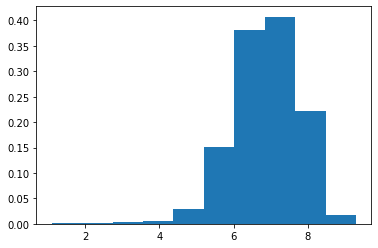

In [261]:
plt.hist(overallMovieRatings,density=True)

In [239]:
def getHistograms(frequentPairs,frequentActors):
    ratingssolo = []
    ratingsduo = []
    for pair in frequentPairs:
        movies1,movies2 = getSoloMovies(pair[0],pair[1],frequentPairs,frequentActors)
        ratings1 = getRatings(movies1)
        ratings2 = getRatings(movies2)
        ratingstg = getRatings(frequentPairs[pair][1])
        ratingssolo.append(ratings1)
        ratingssolo.append(ratings2)
        ratingsduo.append(ratingstg)
    return ratingssolo, ratingsduo

In [260]:
rating_solo, rating_duo = getHistograms(freqPairs,freqActors)

In [263]:
print(np.mean(rating_solo))
print(np.mean(rating_duo))

6.0568511938612515
7.0078889573070615


(array([0.06805808, 0.        , 0.0907441 , 0.29491833, 0.97549909,
        0.43103448, 0.29491833, 0.31760436, 0.04537205, 0.11343013]),
 array([5.  , 5.38, 5.76, 6.14, 6.52, 6.9 , 7.28, 7.66, 8.04, 8.42, 8.8 ]),
 <a list of 10 Patch objects>)

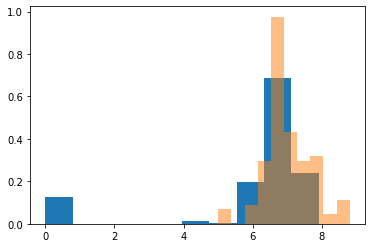

In [262]:
plt.hist(rating_solo,density=True)
plt.hist(rating_duo,density=True,alpha=.5)